<a href="https://colab.research.google.com/github/yashveersinghsohi/face_mask_detection/blob/main/Baseline_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Packages

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2 
import os
from skimage.feature import hog
from tqdm import tqdm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score

# Reading Datasets

In [3]:
ROOT_DIR = "/content/drive/Shareddrives/CIS522/"

with open(ROOT_DIR+"imgs.npy", "rb") as f:
  imgs = np.load(f)

with open(ROOT_DIR+"labels.npy", "rb") as f:
  labels = np.load(f)

# Hog features

In [4]:
ppcr = 8
ppcc = 8
hog_images = []
hog_features = []

for idx in tqdm(range(imgs.shape[0]), total=imgs.shape[0]):
  img = imgs[idx, :, :]
  resized = cv2.resize(img, dsize=(80, 80))
  blur = cv2.GaussianBlur(resized, (5,5), 0)
  features, hog_image = hog(
      blur, 
      orientations=8, 
      pixels_per_cell=(ppcr,ppcc),
      cells_per_block=(2,2),
      block_norm= 'L2',
      visualize=True
    )
  hog_images.append(hog_image)
  hog_features.append(features)

hog_images = np.array(hog_images)
hog_features = np.array(hog_features)

hog_images.shape, hog_features.shape

100%|██████████| 11703/11703 [02:59<00:00, 65.06it/s]


((11703, 80, 80), (11703, 2592))

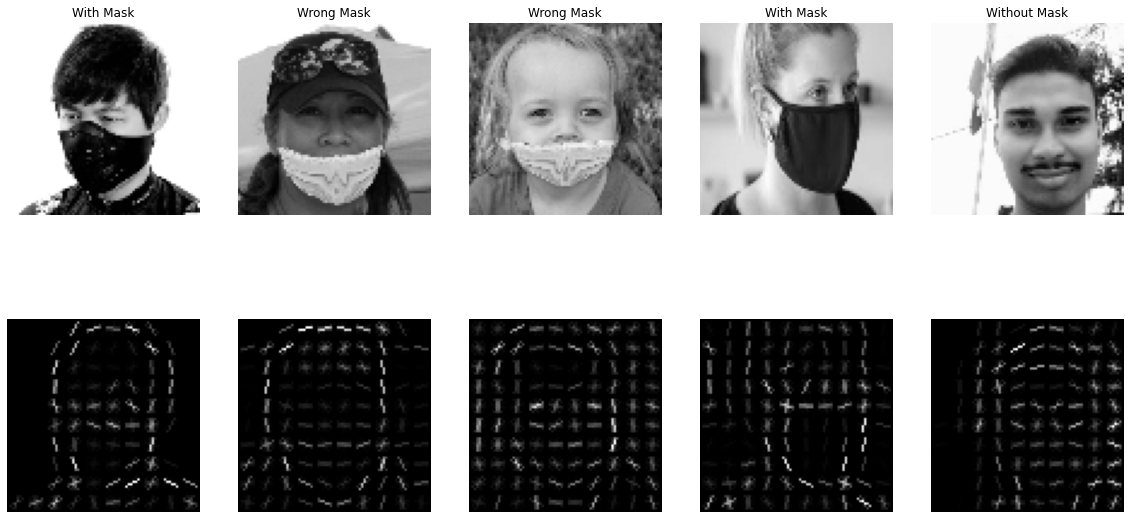

In [13]:
np.random.seed(0)
idxs = np.random.randint(low=0, high=hog_images.shape[0], size=5)

label_map = {0: "With Mask", 1: "Without Mask", 2: "Wrong Mask"}

fig, ax = plt.subplots(2, 5, figsize=(20, 10), sharey=True)
for idx, img_idx in enumerate(idxs):
  img = imgs[img_idx, :, :]
  hog_img = hog_images[img_idx, :, :]
  label = labels[img_idx]

  ax[0, idx].imshow(cv2.resize(img, dsize=(80, 80)), cmap="gray")
  ax[0, idx].axis("off")
  ax[0, idx].set_title(label_map[label], size=12)

  ax[1, idx].imshow(hog_img, cmap="gray")
  ax[1, idx].axis("off")

ax[0, 0].set_ylabel("Original Images", size=12)
ax[1, 0].set_ylabel("HOG Features", size=12)

plt.show()

# Baseline Model

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    hog_features, 
    labels, 
    test_size=0.1, 
    random_state=42
  )

X_train, X_val, y_train, y_val = train_test_split(
    X_train, 
    y_train, 
    test_size=0.1, 
    random_state=42
  )

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((9478, 2592), (1054, 2592), (1171, 2592), (9478,), (1054,), (1171,))

In [15]:
clf = KNeighborsClassifier()
clf.fit(X_train, y_train)

KNeighborsClassifier()

In [30]:
def summarize_performance(clf, X_train, X_val, X_test, y_train, y_val, y_test):
  train_preds = clf.predict(X_train)
  val_preds = clf.predict(X_val)
  test_preds = clf.predict(X_test)

  print("TRAINING")
  print("- Accuracy: {}%".format(round(accuracy_score(y_true=y_train, y_pred=train_preds)*100, 3)))
  print("- F1 Score: {}%".format(round(f1_score(y_true=y_train, y_pred=train_preds, average="macro")*100, 3)))
  print("Confusion Matrix")
  disp = ConfusionMatrixDisplay(confusion_matrix(y_true=y_train, y_pred=train_preds))
  disp.plot()
  plt.show()
  print("-"*100)

  print("\n\nVALIDATION")
  print("- Accuracy: {}%".format(round(accuracy_score(y_true=y_val, y_pred=val_preds)*100, 3)))
  print("- F1 Score: {}%".format(round(f1_score(y_true=y_val, y_pred=val_preds, average="macro")*100, 3)))
  print("Confusion Matrix")
  disp = ConfusionMatrixDisplay(confusion_matrix(y_true=y_val, y_pred=val_preds))
  disp.plot()
  plt.show()
  print("-"*100)

  print("\n\nTESTING")
  print("- Accuracy: {}%".format(round(accuracy_score(y_true=y_test, y_pred=test_preds)*100, 3)))
  print("- F1 Score: {}%".format(round(f1_score(y_true=y_test, y_pred=test_preds, average="macro")*100, 3)))
  print("Confusion Matrix")
  disp = ConfusionMatrixDisplay(confusion_matrix(y_true=y_test, y_pred=test_preds))
  disp.plot()
  plt.show()

TRAINING
- Accuracy: 88.225%
- F1 Score: 87.895%
Confusion Matrix


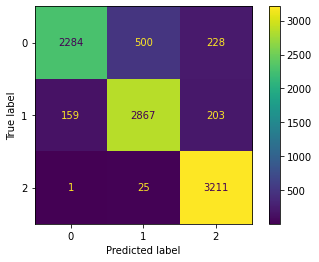

----------------------------------------------------------------------------------------------------


VALIDATION
- Accuracy: 81.594%
- F1 Score: 80.268%
Confusion Matrix


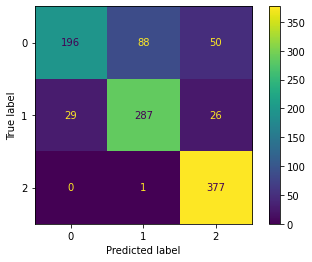

----------------------------------------------------------------------------------------------------


TESTING
- Accuracy: 82.75%
- F1 Score: 82.058%
Confusion Matrix


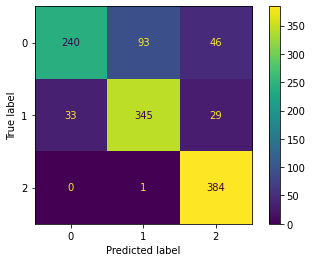

In [31]:
summarize_performance(clf, X_train, X_val, X_test, y_train, y_val, y_test)